# Background Information:                                                                                                    
The Plaicraft project is an initiative that collects data on how people play Minecraft. Specifically, a Minecraft server is run on the web and people enlisted in the initiative are able to play Minecraft in their browser. The initiative collects data on how people play, including a built in proximity voice chat to examine the interactions that are made within the game.

# Question:                                                                                                                  
Within this report, we will be answering the following question: 
We want to ensure that the number of licenses on hand is sufficiently large to accommodate all parallel players with high probability. In order to determine this,
we will analyze the hour of the day, and the day of the week, and find during which time frames there are the most players, and how many players during those time frames.

# Dataset Description:                                                                                                       
We will be using the **sessions.csv** data set to answer our question, which includes $1535$ total observations, with $5$ columns (variables), including the data type of the variable:\
**hashedEmail (character)**: hashed email of players, hashed meaning that the emails have been encrypted to protect privacy\
**start_time (character)**: the time the player joins the Minecraft server, in the format Day/Month/Year Hour:Minute, in GMT\
**end_time (character)**: the time the player leaves the Minecraft server, in the format Day/Month/Year Hour:Minute, in GMT\
**original_start_time (double)**: the time the players joins the Minecraft server, in miliseconds since January $1$st, $1970$\
**original_end_time (double)**: the time the players leaves the Minecraft server, in miliseconds since January $1$st, $1970$

# Methods and Results:
We first load **sessions.csv** and mutate our **sessions.csv** and add useful variables that will help our analysis. The following variables are added (if the same name was used, then the variable was overridden)
- **start_time (dttm)**: Original **start_time**, converted to dttm data type, added seconds, all set to :00
- **end_time (dttm)**: Original **start_time**, converted to dttm data type, added seconds, all set to :00
- **session_length (double)**: The difference in seconds between the **end_time** and **start_time**
- **(5 separate variables) year_start (double), month_start (double), day_start (integer), hour_start (integer), minute_start (integer)**: The year, month, day, hour, minute of **start_time**, respectively.
- **(5 separate variables) year_end (double), month_end (double), day_end (integer), hour_end (integer), minute_end (integer)**: The year, month, day, hour, minute of **end_time**, respectively.
- **startwday (ordered factor)**: The day of the week of **start_time**
- **endwday (ordered factor)**: The day of the week of **end_time**

In [2]:
library(tidyverse)
library(tidymodels)
library(tidyclust)
options(repr.matrix.max.rows = 6)


sessions<-read_csv("https://drive.google.com/uc?export=download&id=14O91N5OlVkvdGxXNJUj5jIsV5RexhzbB")

sessions_tidy<-sessions|>
     mutate(start_time=paste(start_time,":00"),
     end_time=paste(end_time,":00"),
     start_time=dmy_hms(start_time),
     end_time=dmy_hms(end_time),
     session_length=int_length(interval(start_time,end_time)))|>
     select(start_time,end_time,session_length)|>
     mutate(year_start=year(start_time),month_start=month(start_time),day_start=day(start_time),
     hour_start=hour(start_time),minute_start=minute(start_time),startwday=wday(start_time,label=TRUE,abbr=TRUE))|>
     mutate(year_end=year(end_time),month_end=month(end_time),day_end=day(end_time),
     hour_end=hour(end_time),minute_end=minute(end_time),endwday=wday(end_time,label=TRUE,abbr=TRUE))

head(sessions_tidy)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

start_time          end_time            session_length year_start month_start
1 2024-06-30 18:12:00 2024-06-30 18:24:00  720           2024       6          
2 2024-06-17 23:33:00 2024-06-17 23:46:00  780           2024       6          
3 2024-07-25 17:34:00 2024-07-25 17:57:00 1380           2024       7          
4 2024-07-25 03:22:00 2024-07-25 03:58:00 2160           2024       7          
5 2024-05-25 16:01:00 2024-05-25 16:12:00  660           2024       5          
6 2024-06-23 15:08:00 2024-06-23 17:10:00 7320           2024       6          
  day_start hour_start minute_start startwday year_end month_end day_end
1 30        18         12           Sun       2024     6         30     
2 17        23         33           Mon       2024     6         17     
3 25        17         34           Thu       2024     7         25     
4 25         3         22           Thu       2024     7         25     
5 25        16          1           Sat       2024     5         25     
6 23        15          8           Sun       2024     6         23     
  hour_end minute_end endwday
1 18       24         Sun    
2 23       46         Mon    
3 17       57         Thu    
4  3       58         Thu    
5 16       12         Sat    
6 17       10         Sun

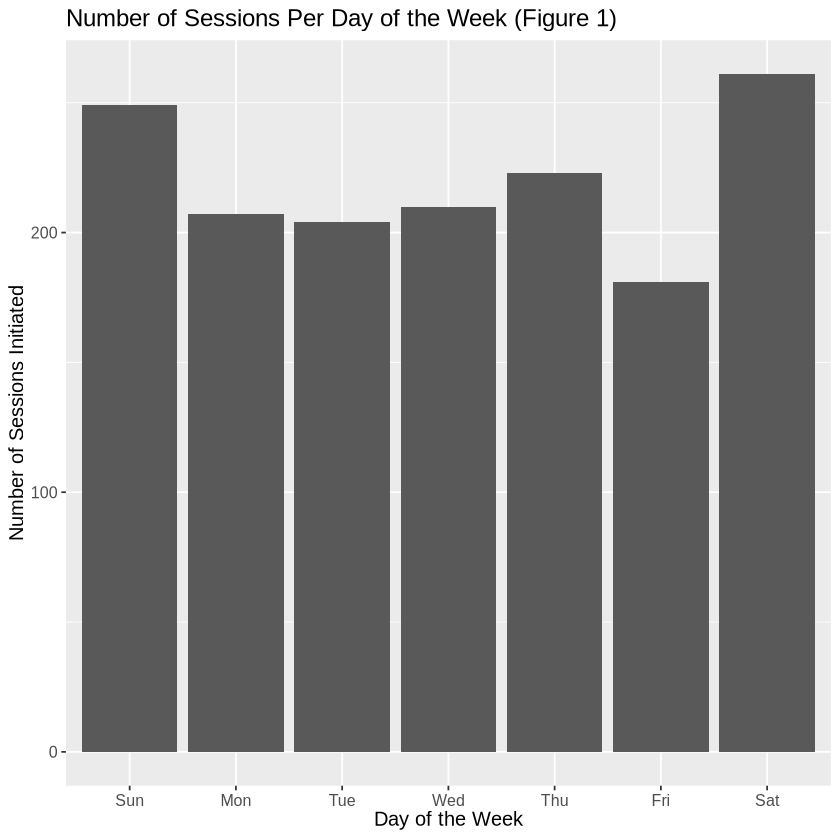

In [3]:
bydayofweek<-ggplot(sessions_tidy,aes(x=startwday))+
geom_bar()+
labs(x="Day of the Week",y="Number of Sessions Initiated") + 
theme(text = element_text(size = 12)) +
ggtitle("Number of Sessions Per Day of the Week (Figure 1)") 
bydayofweek

Here, this bar graph shows that there were some trends in which day of the week had the highest plays. Interestingly, there were less sessions started on Friday compared to any other day. This graph shows that the weekends had higher playership. We can confirm this by obtaining the number of initiated sessions by day of the week, and then sorting in ascending order.

In [24]:
sessions_dayofweek <- sessions_tidy |>
    group_by(startwday) |>
    summarize(num_sessions = n()) |>
    arrange(num_sessions)

sessions_dayofweek

startwday num_sessions
1 Fri       181         
2 Tue       204         
3 Mon       207         
⋮ ⋮         ⋮           
5 Thu       223         
6 Sun       249         
7 Sat       261

From the tibble above, we observe that Saturday and Sunday has the most initiated sessions, which is what we observed from the bar graph.

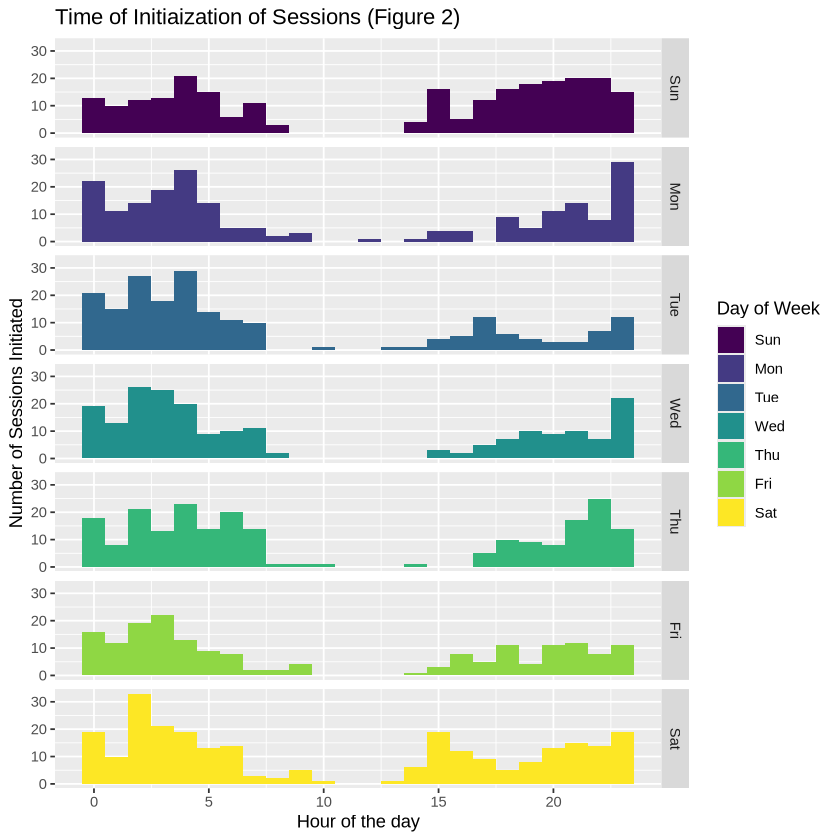

In [19]:
byhour<-ggplot(sessions_tidy,aes(x=hour_start,fill=as_factor(startwday)))+
geom_histogram(bins=24)+
facet_grid(rows = vars(startwday))+
labs(x="Hour of the day",y="Number of Sessions Initiated",fill="Day of Week") + 
ggtitle("Time of Initiaization of Sessions (Figure 2)")
byhour

Here we can see that most sessions are initated around 10pm to 5am.

Next, we want to plot a histogram of the number of sessions initiated on each day, from the first recorded observation to the last. We do this in order to see the activity by month. We can find out when the first and last observation is recorded by sorting **original_start_time** in ascneding order, then using the *head* and *tail* function to view the first and last observations, corresponding to earliest and latest observation, respectively.

In [6]:
library(dplyr)
sessions_ordered <- sessions %>% arrange(original_start_time)

head(sessions_ordered)
tail(sessions_ordered)

hashedEmail                                                     
1 fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d
2 fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d
3 f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d
4 fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d
5 fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d
6 fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d
  start_time       end_time         original_start_time original_end_time
1 06/04/2024 09:35 06/04/2024 10:16 1.71240e+12         1.71240e+12      
2 06/04/2024 09:27 06/04/2024 09:31 1.71240e+12         1.71240e+12      
3 06/04/2024 22:24 06/04/2024 23:33 1.71244e+12         1.71245e+12      
4 06/04/2024 20:56 06/04/2024 22:04 1.71244e+12         1.71244e+12      
5 07/04/2024 00:17 07/04/2024 00:28 1.71245e+12         1.71245e+12      
6 07/04/2024 02:08 07/04/2024 03:35 1.71246e+12         1.71246e+12

hashedEmail                                                     
1 8e0aac3020b3fd9cdef4840b533b4b105aaf1ce1f6f2df3f328ba2a44cecfdc1
2 b622593d2ef8b337dc554acb307d04a88114f2bf453b18fb5d2c80052aeb2319
3 b622593d2ef8b337dc554acb307d04a88114f2bf453b18fb5d2c80052aeb2319
4 a175d4741dc84e6baf77901f6e8e0a06f54809a34e6b5211159bced346f7fb3e
5 7c0ae28a5f85a515a8063f9ed989aa26c5ebcc64f6b7be2948c0b300c2c9bd47
6 b622593d2ef8b337dc554acb307d04a88114f2bf453b18fb5d2c80052aeb2319
  start_time       end_time         original_start_time original_end_time
1 21/09/2024 00:22 21/09/2024 02:12 1.72688e+12         1.72688e+12      
2 21/09/2024 05:07 21/09/2024 06:58 1.72690e+12         1.72690e+12      
3 21/09/2024 21:13 21/09/2024 22:14 1.72695e+12         1.72696e+12      
4 21/09/2024 23:49 22/09/2024 00:23 1.72696e+12         1.72696e+12      
5 24/09/2024 06:30 24/09/2024 06:39 1.72716e+12         1.72716e+12      
6 26/09/2024 06:09 26/09/2024 07:39 1.72733e+12         1.72734e+12

We can observe from the above that the earliest observation's start time is on April $6$th, $2024$, and the latest observation's start time is September $26$th, $2024$. Then, we can use this information for the histogram, and determine the bins. The bins should be equal to the days between the earliest observation and latest observation, inclusive, which is $174$.

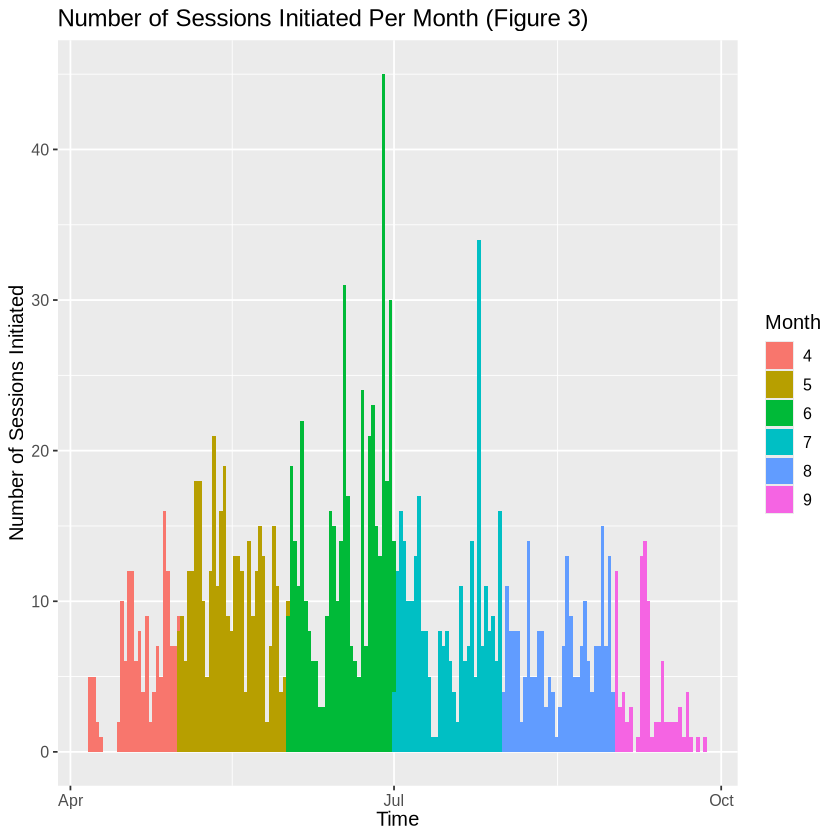

In [7]:
over_time<-ggplot(sessions_tidy,aes(x=start_time, fill = as_factor(month_start)))+
geom_histogram(bins=175)+
labs(x="Time",y="Number of Sessions Initiated",
     fill = "Month")+
ggtitle("Number of Sessions Initiated Per Month (Figure 3)") +
theme(text = element_text(size = 12))
over_time

From the histogram above, with each bin representing one day, we can observe that June has the most activity. To confirm this, we can put it into numbers and see the number of observations by month, and then sort it in ascending order.

In [8]:
sessions_count <- sessions_tidy |>
    group_by(month_start) |>
    summarize(sessions_initiated = n()) |>
    arrange(sessions_initiated)
session_count_daily<-sessions_count|>
arrange(month_start)|>
mutate(sessions_initiated_per_day=sessions_initiated/c(25,31,30,31,31,26))|>#that list is the number of days we have data for in each month
arrange(sessions_initiated_per_day)
sessions_count
session_count_daily

month_start sessions_initiated
1 9            92               
2 4           143               
3 8           221               
4 7           288               
5 5           344               
6 6           447

month_start sessions_initiated sessions_initiated_per_day
1 9            92                 3.538462                 
2 4           143                 5.720000                 
3 8           221                 7.129032                 
4 7           288                 9.290323                 
5 5           344                11.096774                 
6 6           447                14.900000

From the tibble above, we can see that June has the most sessions $447$, which is what we observed from the histogram. We can also see that September has the least number of sessions, at $92$. Furthermore, the second table shows the average number of sessions initiated per day. Possible factors that may have lead to this decrease in play sessions may be due to factors such as the academic season. There still are notable amounts of sessions in the first full weekend on September, but playership plunges shortly afterwards. We also see higher number of sessions initated during the months of July and August. A potential cause for this increase is the summer break for non-unviversity students. Younger players in high school in elementary school have more fre time during the summer break, while university students may be playing throughout their break during the months of May, June, July, and August.

Warning message:
“Removed 475 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 14 rows containing missing values or values outside the scale range
(`geom_bar()`).”


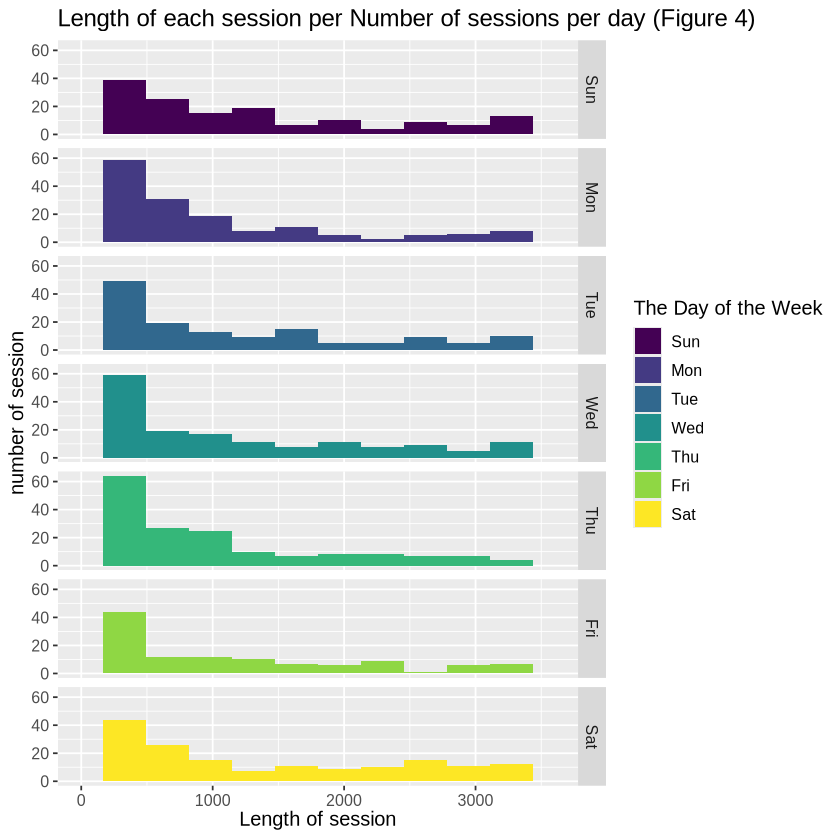

In [9]:
#may want to make this into a logarithmic scale without limits. 
#From this and the number of sessions, we can determine the possibility of having x amount of players on simultaneously.
#also, change to size to a larger, more readable size.
duration<-ggplot(sessions_tidy,aes(x=session_length,fill=startwday))+
geom_histogram(bins=12)+
facet_grid(rows = vars(startwday))+
labs(x="Length of session",y="number of session",fill="The Day of the Week", title = "Length of each session per Number of sessions per day (Figure 4)")+
theme(text = element_text(size = 12)) +
xlim(c(0,3600))
duration

start_time          end_time            session_length year_start month_start
1 2024-06-30 18:12:00 2024-06-30 18:24:00  720           2024       6          
2 2024-06-17 23:33:00 2024-06-17 23:46:00  780           2024       6          
3 2024-07-25 17:34:00 2024-07-25 17:57:00 1380           2024       7          
4 2024-07-25 03:22:00 2024-07-25 03:58:00 2160           2024       7          
5 2024-05-25 16:01:00 2024-05-25 16:12:00  660           2024       5          
6 2024-06-23 15:08:00 2024-06-23 17:10:00 7320           2024       6          
  day_start hour_start minute_start startwday dayofweek
1 30        18         12           Sun       7.758333 
2 17        23         33           Mon       1.981250 
3 25        17         34           Thu       4.731944 
4 25         3         22           Thu       4.140278 
5 25        16          1           Sat       6.667361 
6 23        15          8           Sun       7.630556

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


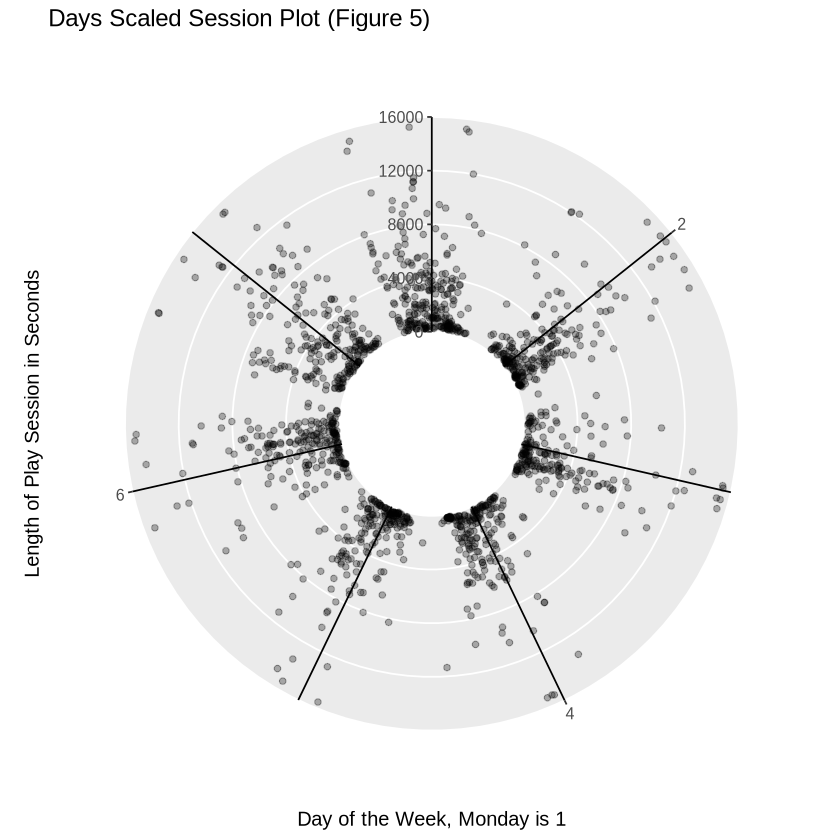

In [23]:
session_scale_wday<-sessions_tidy|>
select(start_time:startwday)|>
mutate(dayofweek=wday(start_time,label=FALSE,week_start=1)+(minute_start/60+hour_start)/24)
head(session_scale_wday)

session_length_wday<-session_scale_wday|>
ggplot(aes(x=dayofweek,y=session_length))+
geom_point(alpha=0.3)+
labs(x="Day of the Week, Monday is 1",y="Length of Play Session in Seconds", title = "Days Scaled Session Plot (Figure 5)")+
theme(text = element_text(size = 12)) +
ylim(0,16000)+#this line is optional.
geom_vline(xintercept=c(1,2,3,4,5,6,7),linetype='solid')+
coord_radial(inner.radius = 0.3, r_axis_inside = TRUE,expand=FALSE)
session_length_wday
#then do clustering on play time and day of the week

The lines represent midnight of each day. We can see that most of the time, the play sessions usually start around the late-night hours. There are noticable gaps during the day, where there are little to no sessions initiated. There also appeared to be more longer play sessions on weekend nights and their following mornings.

In [11]:
clusnums<-tibble(num_clusters=1:20)
scaleday_recipe<-recipe(~dayofweek,data=session_scale_wday)|>
step_scale(all_predictors())|>
step_center(all_predictors())
wday_spec_tune <- k_means(num_clusters = tune()) |>
        set_engine("stats",nstart=10)
#3 
elbow_stats <- workflow() |>
        add_recipe(scaleday_recipe) |>
        add_model(wday_spec_tune) |>
        tune_cluster(resamples = apparent(session_scale_wday), grid = clusnums) |>
        collect_metrics()|>
#4 
        filter(.metric=="sse_within_total")|>
        mutate(total_WSSD=mean)|>
        select(num_clusters,total_WSSD)
elbow_stats

num_clusters total_WSSD
1  1            1534.0000 
2  2             364.6981 
3  3             157.1809 
⋮  ⋮            ⋮         
18 18           2.988194  
19 19           2.117585  
20 20           2.129803

Warning message:
“Removed 4 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 4 rows containing missing values or values outside the scale range
(`geom_line()`).”


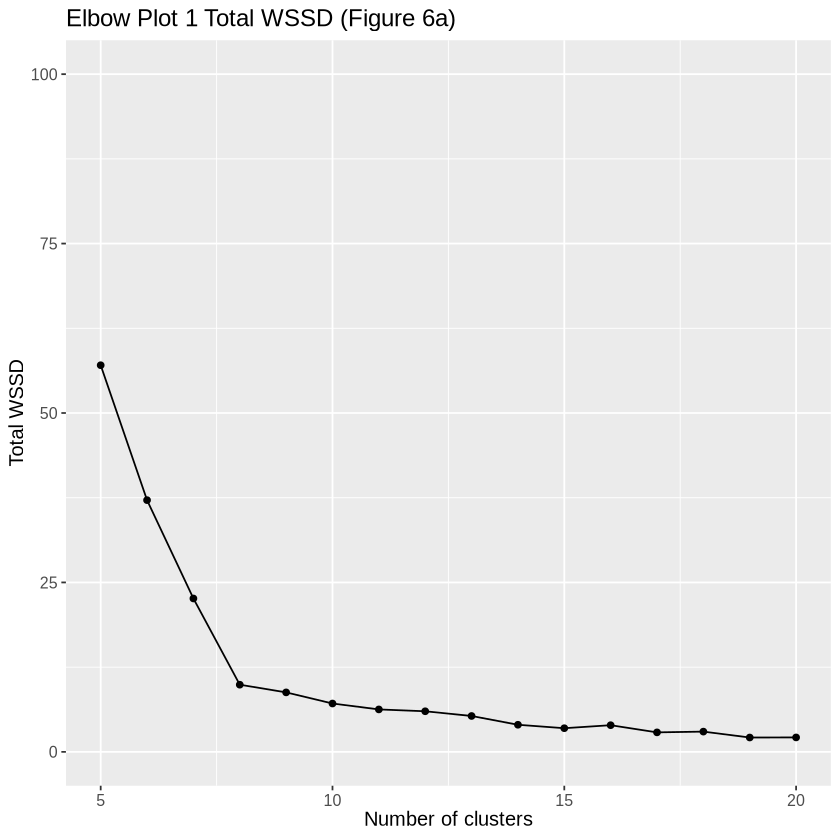

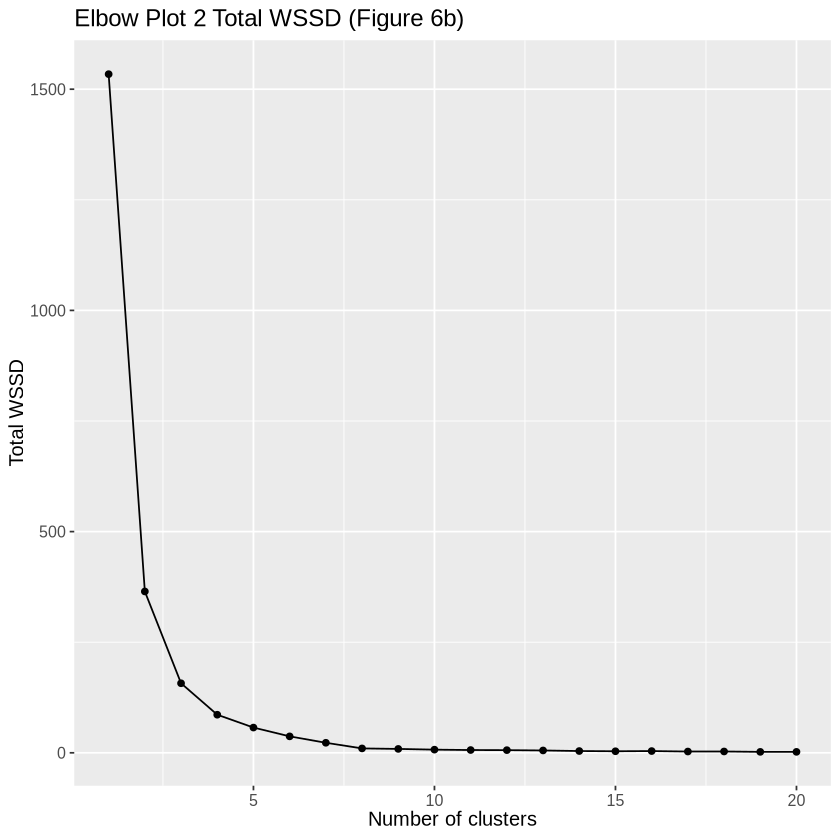

In [12]:
elbow_plot1<-ggplot(elbow_stats,aes(x=num_clusters,y=total_WSSD))+
geom_point()+
geom_line()+
labs(x="Number of clusters", y="Total WSSD", title = "Elbow Plot 1 Total WSSD (Figure 6a)")+
theme(text = element_text(size = 12)) +
xlim(c(5,20))+
ylim(c(0,100))
# No Answer - remove if you provide an answer

elbow_plot2<-ggplot(elbow_stats,aes(x=num_clusters,y=total_WSSD))+
geom_point()+
geom_line()+
labs(x="Number of clusters", y="Total WSSD", title = "Elbow Plot 2 Total WSSD (Figure 6b)") +
theme(text = element_text(size = 12))
# No Answer - remove if you provide an answer
elbow_plot1
elbow_plot2

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


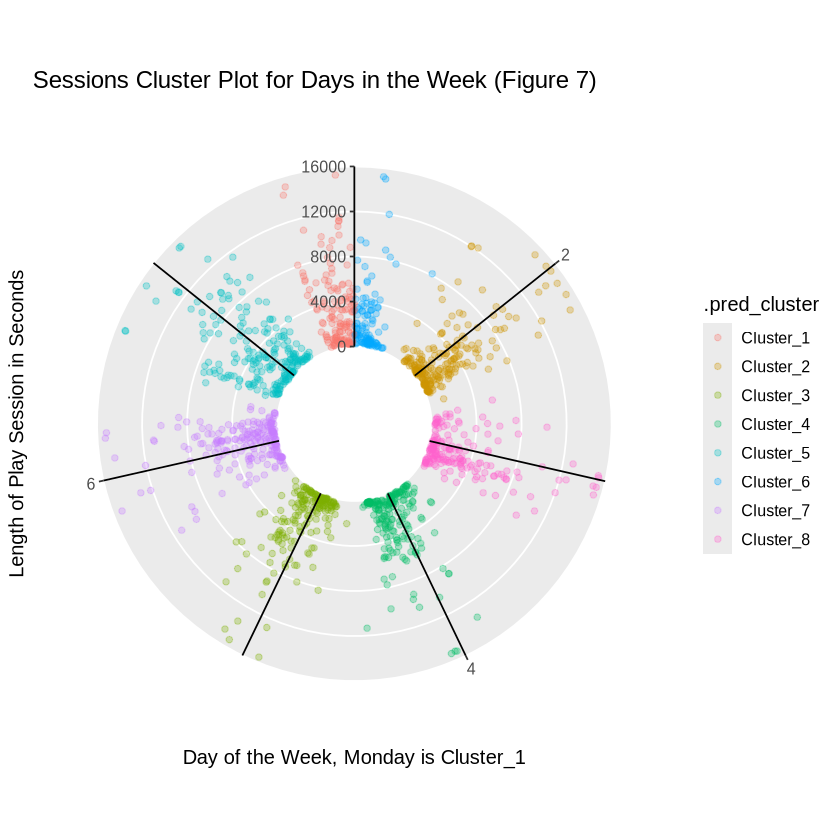

In [22]:
wday_spec1<- k_means(num_clusters = 8) |>
        set_engine("stats",nstart=10)

wday_sessions_final<-workflow()|>
add_recipe(scaleday_recipe)|>
add_model(wday_spec1)|>
fit(session_scale_wday)

wday_sessions_clusters<-augment(wday_sessions_final,session_scale_wday)

session_length_clustered<-wday_sessions_clusters|>
ggplot(aes(x=dayofweek,y=session_length,colour=.pred_cluster))+
geom_point(alpha=0.3)+
labs(x="Day of the Week, Monday is Cluster_1",y="Length of Play Session in Seconds", title = "Sessions Cluster Plot for Days in the Week (Figure 7)")+
ylim(0,16000)+
geom_vline(xintercept=c(1,2,3,4,5,6,7),linetype='solid')+
theme(text = element_text(size = 12)) +
coord_radial(inner.radius = 0.3, r_axis_inside = TRUE,expand=FALSE)
session_length_clustered
     


In [27]:
sessions_perday <- sessions_tidy |>
    group_by(month_start, day_start) |>
    summarize(num_sessions = n()) |>
    arrange(num_sessions)

sessions_perday

`summarise()` has grouped output by 'month_start'. You can override using the
`.groups` argument.


month_start day_start num_sessions
1   4            9        1           
2   6           10        1           
3   7           12        1           
⋮   ⋮           ⋮         ⋮           
164 6            5        28          
165 6           28        34          
166 7           25        38

In [27]:
sessions_perday <- sessions_tidy |>
    group_by(month_start, day_start) |>
    summarize(num_sessions = n()) |>
    arrange(num_sessions)

sessions_perday

`summarise()` has grouped output by 'month_start'. You can override using the
`.groups` argument.


month_start day_start num_sessions
1   4            9        1           
2   6           10        1           
3   7           12        1           
⋮   ⋮           ⋮         ⋮           
164 6            5        28          
165 6           28        34          
166 7           25        38

We can see from here that the day with the most number of sessions initiated is July 25th, at 38 sessions initiated.

Discussion:
Our results included the following:
 -  The weekends had highest player count out of all the days and Friday had the lowest (Figure 1).
 -  The majority of sessions initiated occured from 10pm to 5am (Figure 2).
 -  Out of all the months, June had the most activity (Figure 3) while September had the least (sessions_count). However, it should be noted that there wasn't data for the full months of April and September.
 -  Figure 5 shows sessions usually start during evening hours and long sessions during weekend evenings. It
    also shows little activity during the morning and afternoon of the weekdays.

We now formally answer the question proposed at the beginning of the report,
To start, 38 is the most number of sessions that were initiated within a day, on July 25th. 
Most sessions are initiated between 10pm and 5am, according to figure 2. From figure 3, June had the most activity, at 447 sessions initiated.
Almost all (99.9%) of sessions were shorter than 16000 seconds, which translates to 4 hours 27 minutes, so in 99.9% of cases sessions can reused after 4 hours 27 minutes. The 99% figure was achieved by 100% - 2/1535. Where 1535 is the total number of sessions initiated, and 2 being the number of sessions longer than 16000 seconds, a result from Figure 5.

To conclude, with the assumption that there will not be player count inflation or deflation, a total of **80** separate licenses is enough, as 38 is the maximum number of sessions initiated within a single day. More licenses will be needed during June compared to other months, as that is the month with most activity. Since 99.9% of licenses can be reused after around 4 hours 30 minutes, then there is no need to have more than the sum of the two days with the most sessions initiated (38 + 34 = 72), since 99.9% of those license will be reusable after that time period.

By having **80** licenses, it accounts for potential growth as well. Between the months of May and June, there was a 30% increase in the amount of sessions initiated. If we apply a 25%, continous growth for 3 months to the peak number of sessions initiated (**38**), then we get a maximum of 74 sessions started in a day. We only apply this growth for 3 months because this assumes that growth will only happen for a few months before playership declines once more. By having 80 licenses, this accomodates for unexpected surges in playership due to factors such as organised events where many people play Minecraft together.

Most of the data we gathered is expected to be found. It makes sense for more sessions during the Summer, late nights, and weekends because that is probably when students have the most freetime. Since most classes are throughout the days and semesters run from September to May, June and evening nights would be a plausible assumption to have the most activity. However, something that was slightly odd was how the day with the least ammount of sessions initiated was Friday considering its the last day of the week. One possible reason for this is that we know most sessions were initiated from 10pm - 5am. Since Friday is the day just before the weekend, people may stay up abnormally late to initiate the sessions at an am time causing it to fall in the Saturday data rather than the Friday data. Another possible explanation is that people prefer to meet with friends or do things in real life on Friday nights. 

This project can help researchers look further into optimising server performance to reduce lag and be aware of when more resources are needed to prevent crashes when player traffic is estimated to be high. Maintenance can also be done at better times when it is least likely to interfere with more players. Player base growth is also more likely to occur when admin knows its audience and their popular play times, resulting in more effective advertising/ engagement. If the scale of the admin team's plan for server growth allows for it, targeting international audiences to raise player traffic at other times of the day may also be favourable. 

Some future questions for further analysis include: Taking into account play session trends and audience, how can we effectively increase player to player interaction to build a stronger community? What can be done to ensure the player base remains consistent and there is a steady flow of new players joining as some players stop playing Minecraft? 




In [31]:
check<-wday_sessions_clusters |>
mutate_all(~replace(., is.na(.), 0))
check
play_by_cluster<-check|>
group_by(.pred_cluster)|>
summarize(time=sum(session_length))
play_by_cluster


Warning message:
“There were 2 warnings in `mutate()`.
The first warning was:
ℹ In argument: `.pred_cluster = (structure(function (..., .x = ..1, .y = ..2, .
  = ..1) ...`.
Caused by warning in `[<-.factor`:
! invalid factor level, NA generated
ℹ Run `dplyr::last_dplyr_warnings()` to see the 1 remaining warning.”


.pred_cluster start_time          end_time            session_length
1    Cluster_1     2024-06-30 18:12:00 2024-06-30 18:24:00  720          
2    Cluster_2     2024-06-17 23:33:00 2024-06-17 23:46:00  780          
3    Cluster_3     2024-07-25 17:34:00 2024-07-25 17:57:00 1380          
⋮    ⋮             ⋮                   ⋮                   ⋮             
1533 Cluster_1     2024-07-28 15:36:00 2024-07-28 15:57:00 1260          
1534 Cluster_4     2024-07-25 06:15:00 2024-07-25 06:22:00  420          
1535 Cluster_6     2024-05-20 02:26:00 2024-05-20 02:45:00 1140          
     year_start month_start day_start hour_start minute_start startwday
1    2024       6           30        18         12           Sun      
2    2024       6           17        23         33           Mon      
3    2024       7           25        17         34           Thu      
⋮    ⋮          ⋮           ⋮         ⋮          ⋮            ⋮        
1533 2024       7           28        15         36           Sun      
1534 2024       7           25         6         15           Thu      
1535 2024       5           20         2         26           Mon      
     dayofweek
1    7.758333 
2    1.981250 
3    4.731944 
⋮    ⋮        
1533 7.650000 
1534 4.260417 
1535 1.101389

.pred_cluster time  
1 Cluster_1     521940
2 Cluster_2     706980
3 Cluster_3     535980
⋮ ⋮             ⋮     
6 Cluster_6     293820
7 Cluster_7     668520
8 Cluster_8     585840

ERROR: Error in parse(text = x, srcfile = src): <text>:1:1: unexpected '|'
1: |
    ^
